In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # 使 GPU 0 和 1 可见
import logging
import numpy as np
import sys
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pathlib import Path
from typing import Callable, Optional, Sequence, Union
from pymoo.indicators.gd import GD
from pymoo.indicators.gd_plus import GDPlus
from pymoo.indicators.igd import IGD
from pymoo.indicators.igd_plus import IGDPlus
from matplotlib import pyplot as plt

BASE_PATH = os.path.join(
   '/home/tzhouaq/offline-moo/'
)
sys.path.append(BASE_PATH)
CONDITIONAL_TASKS = []
# sys.path.append(os.path.join(BASE_PATH, 'off_moo_baselines'))
import off_moo_bench as ob
sys.path.append(os.path.join(BASE_PATH, 'off_moo_baselines'))
from mo_solver.ddom.design_baselines.diff.trainer import RvSDataModule
from mo_solver.ddom.design_baselines.diff.nets import (
    DiffusionTest, DiffusionScore, Swish
)
from mo_solver.ddom.design_baselines.diff.lib.sdes import (
    PluginReverseSDE, VariancePreservingSDE, UnconditionPluginReverseSDE
)
from mo_solver.ddom.design_baselines.diff.forward import ForwardModel
from utils import set_seed
 

Auto Configuration Succeed!, Using database /home/tzhouaq/offline-moo/off_moo_bench/problem/mo_nas/database.
Configuration Succeed!
Auto Configuration Succeed!, Using database /home/tzhouaq/offline-moo/off_moo_bench/problem/mo_nas/database.


In [2]:
from utils import process_args 
sys.argv = ['--model=MOBO', '--train_mode=Vallina','--task=re23','--use_wandb=False','--n_epochs=10','--retrain_model=False','--seed=1000']
config = process_args(return_dict=True)

All config: {'results_dir': './results', 'model_save_dir': './model', 'use_wandb': False, 'run_type': 'train', 'seed': 1000, 'retrain_model': False, 'num_solutions': 256, 'solver_n_gen': 50, 'solver_init_method': 'nds', 'model': 'MOBO', 'train_mode': 'Vallina', 'task': 're23', 'n_epochs': 10, 'data_pruning': False, 'permutation_n_gen': 200, 'sequence_n_gen': 200, 'train_gp_data_size': 256, 'normalize_xs': True, 'normalize_ys': True, 'to_logits': False, 'record_hist': True}


In [3]:
# toy example
# te1 

# Synthetic Functions 
# "dtlz1 dtlz2 dtlz3 dtlz4 dtlz5 dtlz6 dtlz7 zdt1 zdt2 zdt3 zdt4 zdt6 vlmop1 vlmop2 vlmop3 omnitest"

# RE
# "re21 re22 re23 re24 re25 re31 re32 re33 re34 re35 re36 re37 re41 re42 re61"

# MO-NAS
# "nb201_test c10mop1 c10mop2 c10mop3 c10mop4 c10mop5 c10mop6 c10mop7 c10mop8 c10mop9 in1kmop1 in1kmop2 in1kmop3 in1kmop4 in1kmop5 in1kmop6 in1kmop7 in1kmop8 in1kmop9"

# MORL
# "mo_hopper_v2 mo_swimmer_v2"

# MOCO 
# "bi_tsp_20 bi_tsp_50 bi_tsp_100 bi_tsp_500 tri_tsp_20 tri_tsp_50 tri_tsp_100 bi_cvrp_20 bi_cvrp_50 bi_cvrp_100 bi_kp_50 bi_kp_100 bi_kp_200"

# Scientific Design
# "zinc regex rfp molecule"

In [4]:
# from utils import process_args 
# sys.argv = ['--model=End2End', '--train_mode=Vallina','--task=re21','--use_wandb=False','--n_epochs=10','--retrain_model=False','--seed=1000']
# config = process_args(return_dict=True)

# results_dir = os.path.join('/home/tzhouaq/offline-moo/', "results")
# model_save_dir = os.path.join('/home/tzhouaq/offline-moo/', "model")
 
# config["results_dir"] = results_dir
# config["model_save_dir"] = model_save_dir
# config["data_pruning"] = True
# config['data_preserved_ratio']= 1.0
# config['hidden_size']=2048
# config['inverse_lr']=1e-4
# # config['batch_size']= 16
# config['inverse_lr_decay']=0.98
# config['n_epochs']= 200

# config['simple_clip']=True
# config['debais']=True
# config["record_hist"]=False
# config['dropout']=0. 
# config['augment']=True
# config['condition_training']=False
# config['model_ckpt'] = None 
# # config['normalize_xs'] = False
# # config['normalize_ys'] = False

In [5]:
import os 
import sys 
import wandb 
import torch 
import numpy as np 
import pandas as pd 
import datetime 
import json 
from copy import deepcopy

# BASE_PATH = os.path.join(
#     os.path.dirname(os.path.abspath(__file__)),
#     "..", ".."
# )
# sys.path.append(BASE_PATH)

import off_moo_bench as ob
from pymoo.algorithms.moo.nsga2 import NSGA2
from utils import set_seed, get_quantile_solutions
from off_moo_baselines.data import get_dataloader
from off_moo_baselines.mobo import get_mobo_solver
from off_moo_baselines.mobo.mobo_utils import tkwargs
from off_moo_bench.task_set import *
from off_moo_bench.evaluation.metrics import hv
from off_moo_bench.evaluation.plot import plot_y


 

In [6]:

def run(config: dict):
    if config["task"] in ALLTASKSDICT.keys():
        config["task"] = ALLTASKSDICT[config["task"]]
    
    results_dir = os.path.join(config['results_dir'], 
                               f"{config['model']}-{config['train_mode']}-{config['task']}")
    config["results_dir"] = results_dir 
    
    ts = datetime.datetime.utcnow() + datetime.timedelta(hours=+8)
    ts_name = f"-ts-{ts.year}-{ts.month}-{ts.day}_{ts.hour}-{ts.minute}-{ts.second}"
    run_name = f"{config['model']}-{config['train_mode']}-seed{config['seed']}-{config['task']}"
    
    logging_dir = os.path.join(config['results_dir'], run_name + ts_name)
    os.makedirs(logging_dir, exist_ok=True)

    if config['use_wandb']:
        if 'wandb_api' in config.keys():
            wandb.login(key=config['wandb_api'])

        wandb.init(
            project="Offline-MOO",
            name=run_name + ts_name,
            config=config,
            group=f"{config['model']}-{config['train_mode']}",
            job_type=config['run_type'],
            mode="online",
            dir=os.path.join(config['results_dir'], '..')
        )
    
    with open(os.path.join(logging_dir, "params.json"), "w") as f:
        json.dump(config, f, indent=4)

    set_seed(config['seed'])

    task = ob.make(config['task'])
    pf = task.problem.get_pareto_front()
    if config['normalize_ys']:
        pf = task.normalize_y(pf)
    X = task.x.copy()
    y = task.y.copy()
    
    if config["data_pruning"]:
        X, y = task.get_N_non_dominated_solutions(
            N=int(X.shape[0] * config["data_preserved_ratio"]),
            return_x=True, return_y=True
        )
    
    X_test = task.x_test.copy()
    y_test = task.y_test.copy()
    
    if config['to_logits']:
        assert task.is_discrete 
        task.map_to_logits()
        X = task.to_logits(X)
        X_test = task.to_logits(X_test)
    if config['normalize_xs']:
        task.map_normalize_x()
        X = task.normalize_x(X)
        X_test = task.normalize_x(X_test)
    if config['normalize_ys']:
        task.map_normalize_y()
        y = task.normalize_y(y)
        y_test = task.normalize_y(y_test)
    
    if config['to_logits']:
        data_size, n_dim, n_classes = tuple(X.shape)
        X = X.reshape(-1, n_dim * n_classes)
        X_test = X_test.reshape(-1, n_dim * n_classes)
    else:
        data_size, n_dim = tuple(X.shape)
    n_obj = y.shape[1]
        
    model_save_dir = config['model_save_dir']
    os.makedirs(model_save_dir, exist_ok=True)
    
    MOBO_Solver = get_mobo_solver(config["train_mode"])\
        (
            config=config,
            X_init=torch.Tensor(X).to(**tkwargs),
            Y_init=torch.Tensor(y).to(**tkwargs),
            solver_kwargs={
                "ref_point": torch.Tensor(1.1 * task.nadir_point).to(**tkwargs),
                "xl": task.xl,
                "xu": task.xu,
            },
            train_gp_data_size=config["train_gp_data_size"],
            output_size=config["num_solutions"],
            negate=True
        )
    
    res_x = MOBO_Solver.run()
    if config['to_logits']:
        res_x = res_x.reshape(-1, n_dim, n_classes)
    if config['normalize_xs']:
        task.map_denormalize_x()
        res_x = task.denormalize_x(res_x)
    if config['to_logits']:
        task.map_to_integers()
        res_x = task.to_integers(res_x)
    
    res_y = task.predict(res_x)
    visible_masks = np.ones(len(res_y))
    visible_masks[np.where(np.logical_or(np.isinf(res_y), np.isnan(res_y)))[0]] = 0
    visible_masks[np.where(np.logical_or(np.isinf(res_x), np.isnan(res_x)))[0]] = 0
    res_x = res_x[np.where(visible_masks == 1)[0]]
    res_y = res_y[np.where(visible_masks == 1)[0]]
    
    res_y_75_percent = get_quantile_solutions(res_y, 0.75)
    res_y_50_percent = get_quantile_solutions(res_y, 0.50)
    
    nadir_point = task.nadir_point
    if config['normalize_ys']:
        res_y = task.normalize_y(res_y)
        nadir_point = task.normalize_y(nadir_point)
        res_y_50_percent = task.normalize_y(res_y_50_percent)
        res_y_75_percent = task.normalize_y(res_y_75_percent)
        
    _, d_best = task.get_N_non_dominated_solutions(
        N=6000, 
        return_x=False, return_y=True
    )
    
    np.save(file=os.path.join(logging_dir, "res_x.npy"), arr=res_x)
    np.save(file=os.path.join(logging_dir, "res_y.npy"), arr=res_y)
    plot_y(res_y, save_dir=logging_dir, config=config,
           nadir_point=nadir_point, d_best=d_best, pareto_front=pf,)
        
    d_best_hv = hv(nadir_point, d_best, config['task'])
    hv_value = hv(nadir_point, res_y, config['task'])
    hv_value_50_percentile = hv(nadir_point, res_y_50_percent, config['task'])
    hv_value_75_percentile = hv(nadir_point, res_y_75_percent, config['task'])
    
    print(f"Hypervolume (100th): {hv_value:4f}")
    print(f"Hypervolume (75th): {hv_value_75_percentile:4f}")
    print(f"Hypervolume (50th): {hv_value_50_percentile:4f}")
    print(f"Hypervolume (D(best)): {d_best_hv:4f}")


    # 假设 pf 是你的帕累托前沿
    ind_gd = GD(pf)
    ind_gdp = GDPlus(pf)
    ind_igd = IGD(pf)
    ind_igdp = IGDPlus(pf)

    # 计算 MOO的各种 指标
    gd_plus_value = ind_gd.do(res_y)
    gdp_plus_value = ind_gdp.do(res_y)
    igd_value = ind_igd.do(res_y)
    igd_plus_value = ind_igdp.do(res_y)

    print("GD:", gd_plus_value)
    print("GD+:", gdp_plus_value)
    print("IGD:", igd_value)
    print("IGD+:", igd_plus_value)
    indicators_results = {
        "GD": gd_plus_value,
        "GD+": gd_plus_value,
        "IGD": igd_value,
        "IGD+": igd_plus_value,
    }
    hv_results = {
        "hypervolume/D(best)": d_best_hv,
        "hypervolume/100th": hv_value, 
        "hypervolume/75th": hv_value_75_percentile,
        "hypervolume/50th": hv_value_50_percentile,
        "evaluation_step": 1,
    }

    indicators_results.update(hv_results)

 
    
    df = pd.DataFrame([hv_results])
    filename = os.path.join(logging_dir, "hv_results.csv")
    df.to_csv(filename, index=False)
    
    if config["use_wandb"]:
        wandb.log(hv_results)

    return hv_value, igd_value

All config: {'results_dir': './results', 'model_save_dir': './model', 'use_wandb': False, 'run_type': 'train', 'seed': 1000, 'retrain_model': False, 'num_solutions': 256, 'solver_n_gen': 50, 'solver_init_method': 'nds', 'model': 'MOBO', 'train_mode': 'Vallina', 'task': 're23', 'n_epochs': 10, 'data_pruning': False, 'permutation_n_gen': 200, 'sequence_n_gen': 200, 'train_gp_data_size': 256, 'normalize_xs': True, 'normalize_ys': True, 'to_logits': False, 'record_hist': True}
******************************************Seed40****************************************************
Hypervolume (100th): 4.839553
Hypervolume (75th): 4.831324
Hypervolume (50th): 4.175062
Hypervolume (D(best)): 4.750722
GD: 0.3238205253525939
GD+: 0.32381513321572786
IGD: 0.051489659648949755
IGD+: 0.00029774155640549906
******************************************Seed41****************************************************
Hypervolume (100th): 4.839215
Hypervolume (75th): 4.831596
Hypervolume (50th): 4.214307
Hypervolu

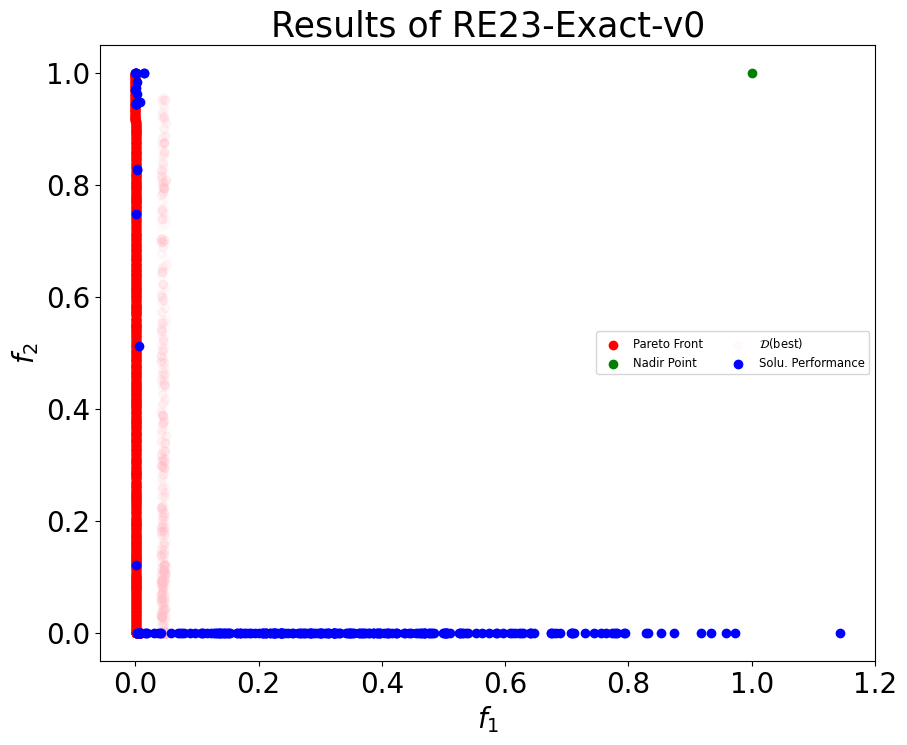

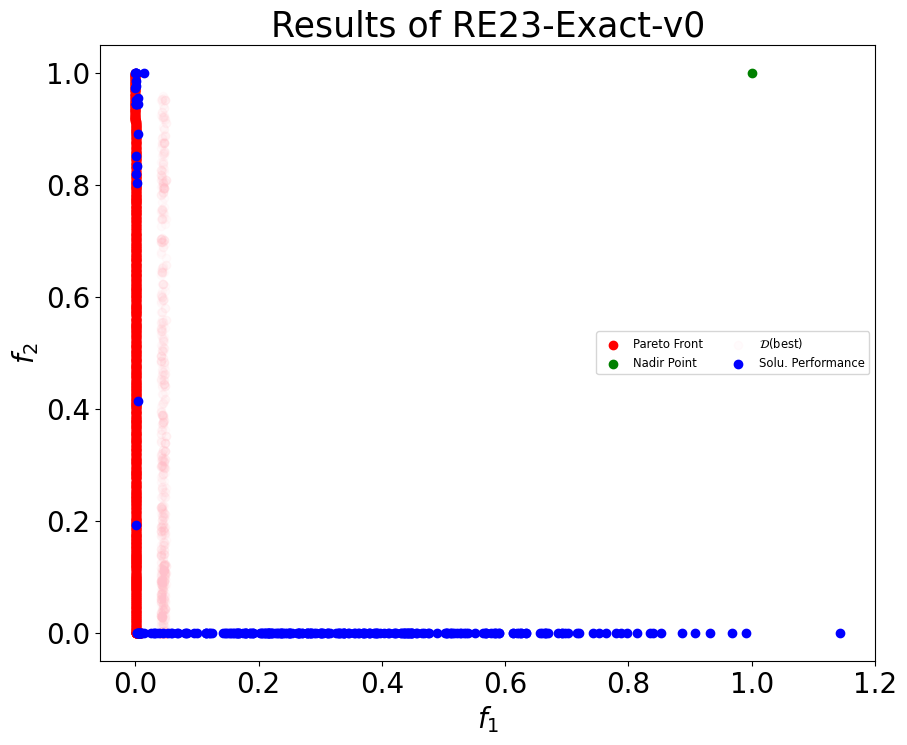

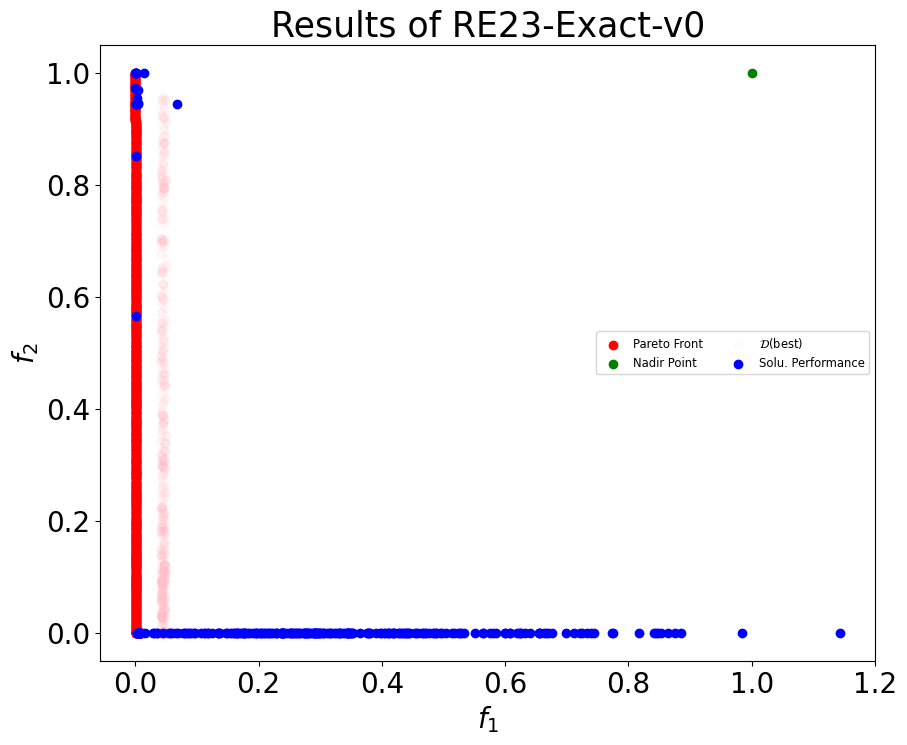

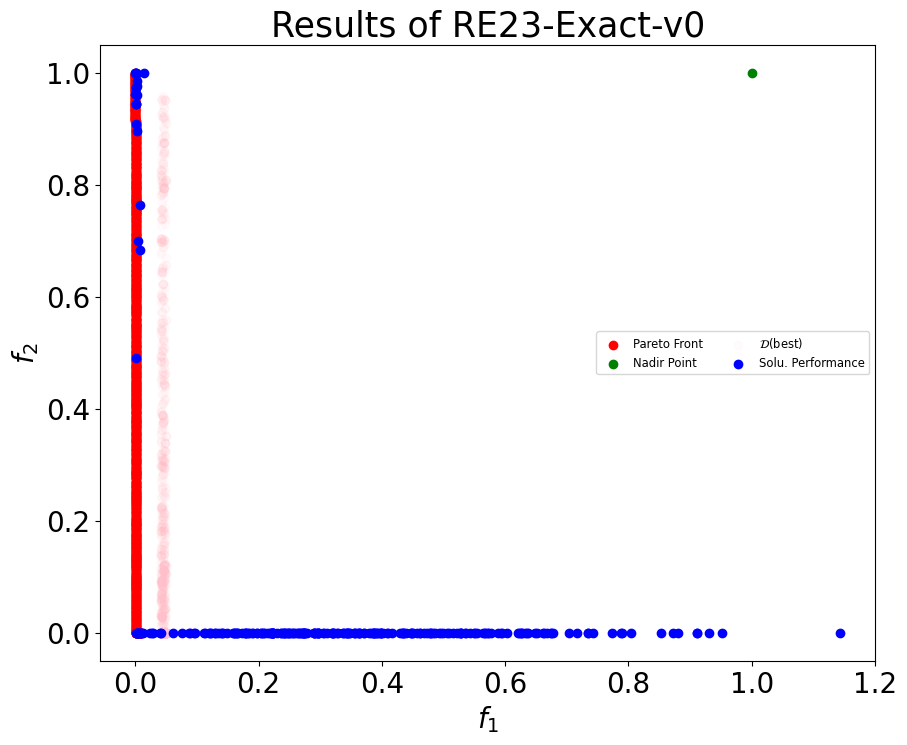

In [7]:
     

from utils import process_args 
config = process_args(return_dict=True)

results_dir = os.path.join(BASE_PATH, "results")
model_save_dir = os.path.join(BASE_PATH, "model")

config["results_dir"] = results_dir
config["model_save_dir"] = model_save_dir

config["train_gp_data_size"] = 256

solutions = []
run_trials = 4
seed_list = [40,41,42,43]
HV_list = []
IGD_list = []
for seed in seed_list:
    print(f"******************************************Seed{seed}****************************************************")
    config['seed'] = seed
    hv_value, igd_value = run(config)
    HV_list.append(hv_value)
    IGD_list.append(igd_value)



In [8]:
print(f"Average Hypervolume: {np.mean(HV_list)}, std: {np.std(HV_list)}")
print(f"Average IGD: {np.mean(IGD_list)}, std: {np.std(IGD_list)}")

Average Hypervolume: 4.839283861931534, std: 0.0002539254467067699
Average IGD: 0.06397303002372579, std: 0.014778249090229428


All config: {'results_dir': './results', 'model_save_dir': './model', 'use_wandb': False, 'run_type': 'train', 'seed': 1000, 'retrain_model': False, 'num_solutions': 256, 'solver_n_gen': 50, 'solver_init_method': 'nds', 'model': 'MOBO', 'train_mode': 'Vallina', 'task': 're23', 'n_epochs': 10, 'data_pruning': False, 'permutation_n_gen': 200, 'sequence_n_gen': 200, 'train_gp_data_size': 256, 'normalize_xs': True, 'normalize_ys': True, 'to_logits': False, 'record_hist': True}
******************************************Seed40****************************************************
Hypervolume (100th): 4.839557
Hypervolume (75th): 4.788471
Hypervolume (50th): 4.508658
Hypervolume (D(best)): 4.750722
GD: 0.22475411139072024
GD+: 0.22475186046186907
IGD: 0.05355463643394363
IGD+: 0.00027841583729909167
******************************************Seed41****************************************************
Hypervolume (100th): 4.839660
Hypervolume (75th): 4.777830
Hypervolume (50th): 4.523868
Hypervolu

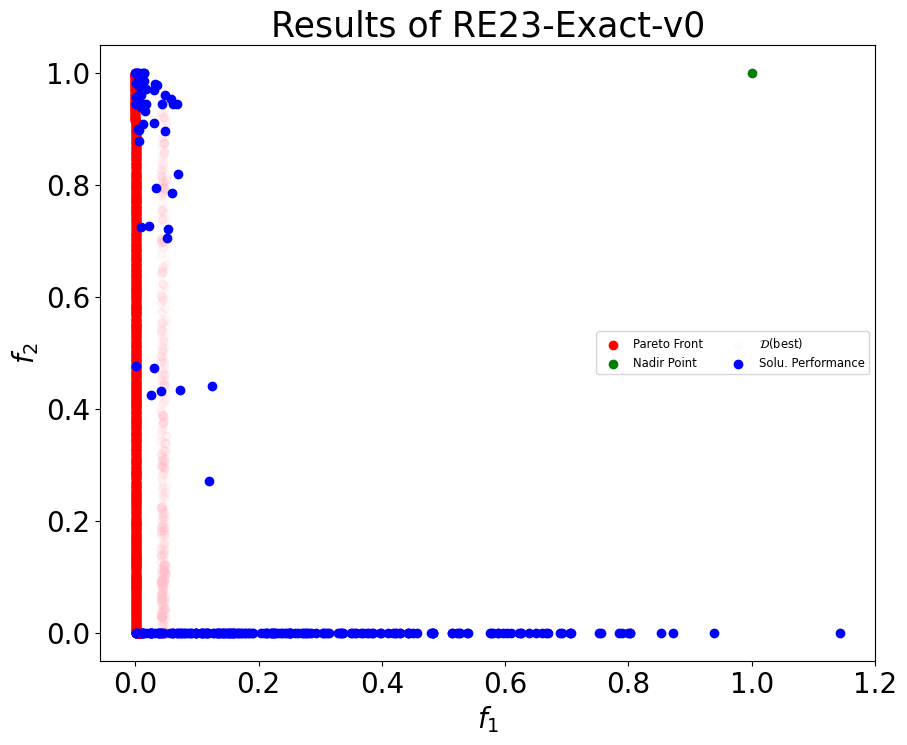

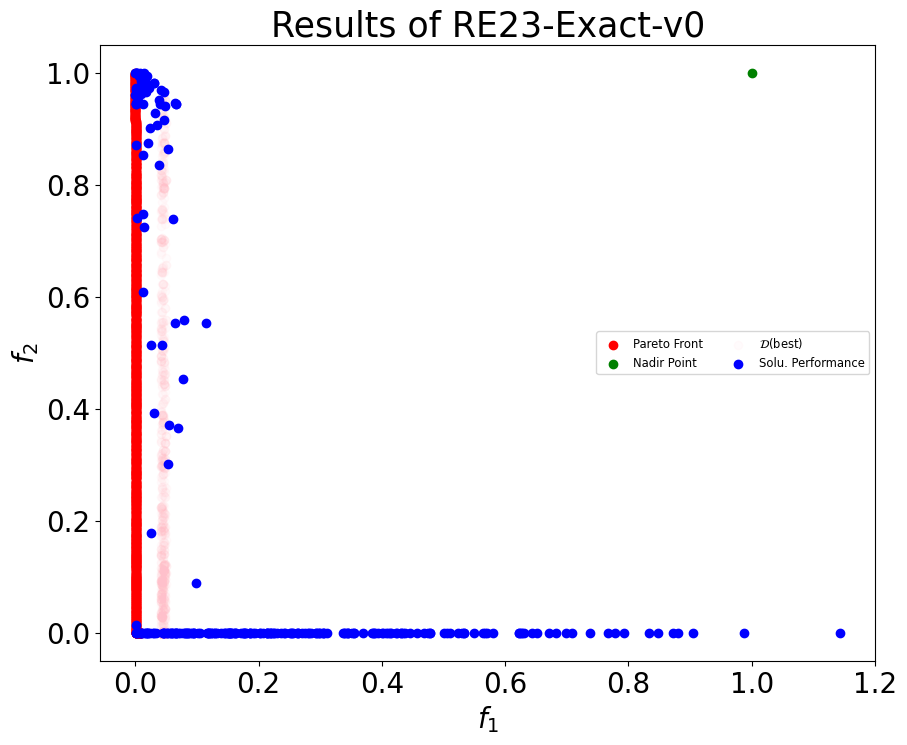

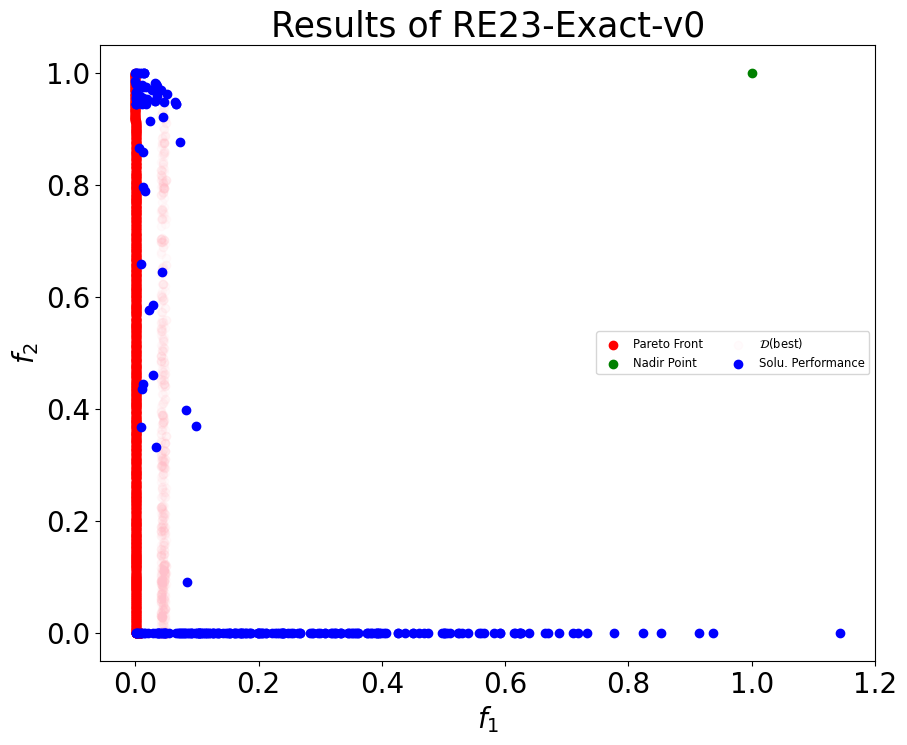

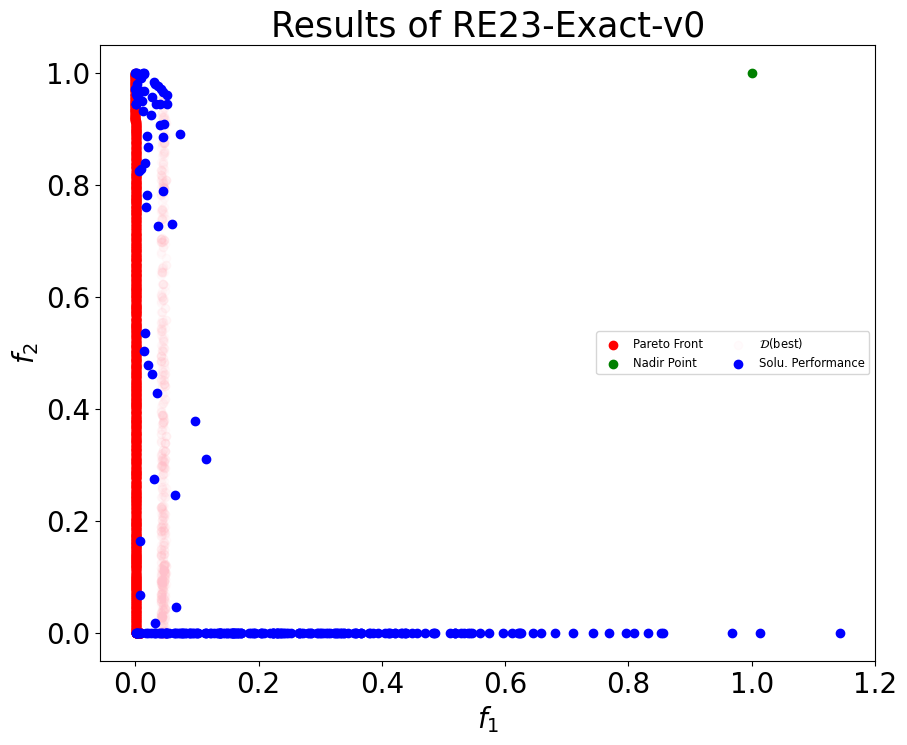

In [9]:
     

from utils import process_args 
config = process_args(return_dict=True)

results_dir = os.path.join(BASE_PATH, "results")
model_save_dir = os.path.join(BASE_PATH, "model")

config["results_dir"] = results_dir
config["model_save_dir"] = model_save_dir

config["train_gp_data_size"] = 1

solutions = []
run_trials = 4
HV_list = []
IGD_list = []
seed_list = [40,41,42,43]
for seed in seed_list:
    print(f"******************************************Seed{seed}****************************************************")
    config['seed'] = seed
    hv_value, igd_value = run(config)
    HV_list.append(hv_value)
    IGD_list.append(igd_value)



In [10]:
print(f"Average Hypervolume: {np.mean(HV_list)}, std: {np.std(HV_list)}")
print(f"Average IGD: {np.mean(IGD_list)}, std: {np.std(IGD_list)}")

Average Hypervolume: 4.839475999722307, std: 0.00021802266042840338
Average IGD: 0.03711337760191228, std: 0.009973737279278843
